In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Xe137Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [4]:
categories_list = ['0.01x','0.1x','0.3x','1x','3.0x','10x','30.0x','1e+02x']
outputdir = '/p/lustre1/lenardo1/sensitivity_output/June23_2020_Xe137_test/'

all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if filename.endswith('.h5')]

dfdict = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
    dfdict[category] = pd.concat(df_list,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict[category])))


Loading data for 0.01x
---> Loaded 5000 toy datasets
Loading data for 0.1x
---> Loaded 5000 toy datasets
Loading data for 0.3x
---> Loaded 5000 toy datasets
Loading data for 1x
---> Loaded 5000 toy datasets
Loading data for 3.0x
---> Loaded 5000 toy datasets
Loading data for 10x
---> Loaded 5000 toy datasets
Loading data for 30.0x
---> Loaded 5000 toy datasets
Loading data for 1e+02x
---> Loaded 4300 toy datasets


In [5]:
baselinedir = '/p/lustre1/lenardo1/sensitivity_output/June23_2020_Xe137_test/'
all_files = os.listdir(baselinedir)
h5_files = [filename for filename in all_files if (filename.endswith('.h5') and '_1x_' in filename)]
df_list = [pd.read_hdf(baselinedir+filename) for filename in h5_files]
baselinedf = pd.concat(df_list,ignore_index=True)

dfdict['Baseline'] = baselinedf




In [6]:
# Get the median values of lambda

maskdict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict[key])/len(maskdict[key])))
            
    
        

Running 0.01x
---> Convergence fraction: 1.0
Running 0.1x
---> Convergence fraction: 1.0
Running 0.3x
---> Convergence fraction: 0.997
Running 1x
---> Convergence fraction: 0.969
Running 3.0x
---> Convergence fraction: 0.963
Running 10x
---> Convergence fraction: 0.955
Running 30.0x
---> Convergence fraction: 0.921
Running 1e+02x
---> Convergence fraction: 0.88
Running Baseline
---> Convergence fraction: 0.969


Running 0.01x
---> Median 90%CL on signal counts: 8.10675562969141
Running 0.1x
---> Median 90%CL on signal counts: 8.206839032527107
Running 0.3x
---> Median 90%CL on signal counts: 8.206839032527107
Running 1x
---> Median 90%CL on signal counts: 8.607172643869891
Running 3.0x
---> Median 90%CL on signal counts: 9.658048373644704
Running 10x
---> Median 90%CL on signal counts: 12.110091743119266
Running 30.0x
---> Median 90%CL on signal counts: 15.963302752293579
Running 1e+02x
---> Median 90%CL on signal counts: 24.220183486238533
Running Baseline
---> Median 90%CL on signal counts: 8.607172643869891


Text(0.5, 0, '90% CL on signal counts for given toy')

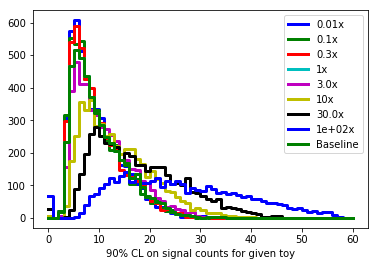

In [7]:
histdict = dict()
mediandict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    histdict[key] = hl.hist(dfdict[key]['90CL_crossing'].loc[maskdict[key]], bins=np.linspace(0.,60.,61))
    
    mediandict[key] = np.median(dfdict[key]['90CL_crossing'].loc[maskdict[key]])
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict[key]))
    
    hl.plot1d(histdict[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
            
 

0.01	1.062
 0.1	1.049
 0.3	1.049
 1.0	 1.0
 1.0	 1.0
 3.0	0.8912
10.0	0.7107
30.0	0.5392
100.0	0.3554


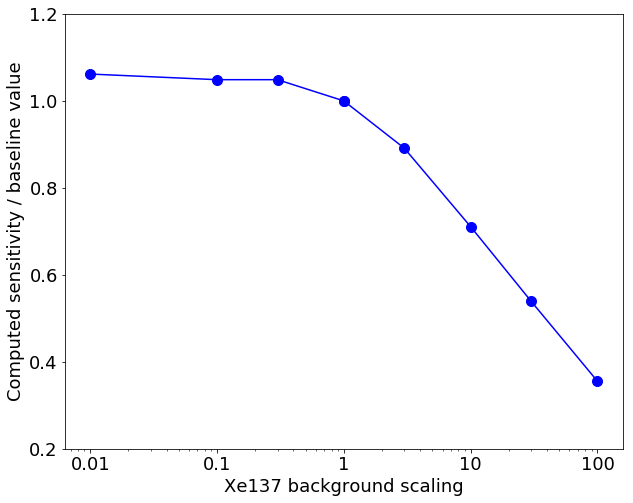

In [18]:
#plt.plot(1.,1.,'ob',markersize=10)

x_points = [1.]
y_points = [1.]

for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append((1/value)/(1/mediandict['Baseline']))
    
x_points = np.array(x_points)
y_points = np.array(y_points)
    
sorted_idxs = np.argsort(x_points)

x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]
    
plt.plot(x_points,y_points,'-ob',markersize=10)
plt.xscale('log')
plt.ylim(0.2,1.2)
plt.ylabel('Computed sensitivity / baseline value')
plt.xlabel('Xe137 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.,],['0.01','0.1','1','10','100'])

plt.savefig('xe137_sensitivity_vs_scale_factor.png',dpi=200,bbox_inches='tight')

for i in range(len(x_points)):

    print('{:4.4}\t{:4.4}'.format(x_points[i],y_points[i]))
    